# 2.0.0 Generating the Schapiro Graph

Place to work on generating the graph laid out in the [Shapiro paper](https://www.nature.com/articles/nn.3331#Sec16).

## Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn,networkx

Mon Aug 17 2020 15:35:56 

CPython 3.8.5
IPython 7.16.1

numpy 1.19.1
matplotlib 3.2.2
seaborn 0.10.1
networkx 2.4

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-42-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 4
interpreter: 64bit
Git hash   : 4acae10c2906254aab47f39e7ecc6bf760ab2943
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

## Imports

In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

## Visualizing Graphs

In [5]:
G = nx.petersen_graph()

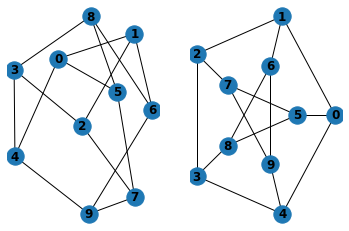

In [6]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
plt.subplot(122)
nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

## Adding Nodes

In [7]:
G = nx.Graph()

In [8]:
G.add_node(1)

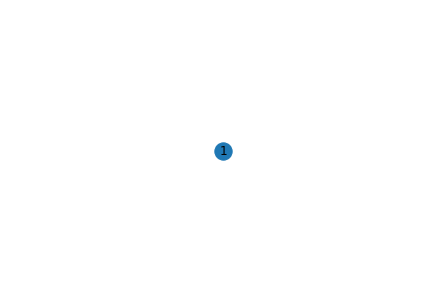

In [9]:
nx.draw(G, with_labels=True)

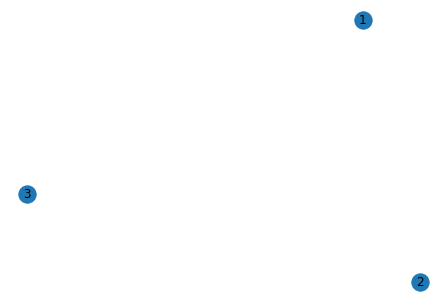

In [10]:
G.add_nodes_from([2,3])
nx.draw(G, with_labels=True)

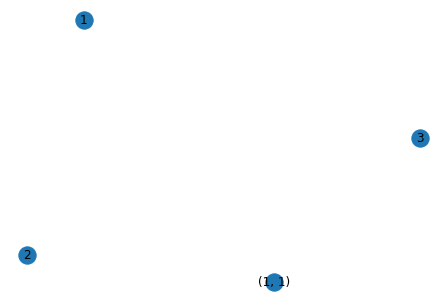

In [11]:
G.add_node((1,1))
nx.draw(G, with_labels=True)

## Removing Nodes

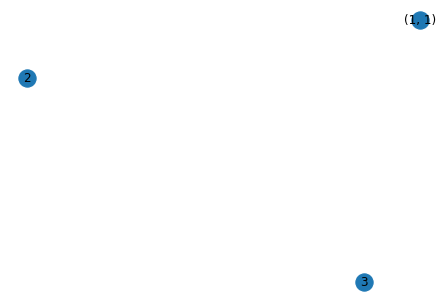

In [12]:
G.remove_node(1)
nx.draw(G, with_labels=True)

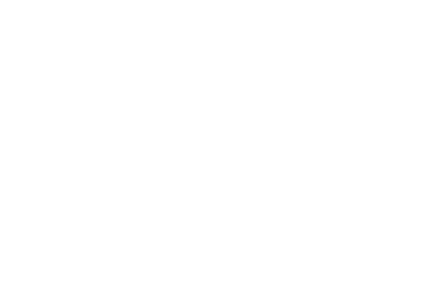

In [13]:
G.remove_nodes_from(list(G.nodes))
nx.draw(G, with_labels=True)

## Edges

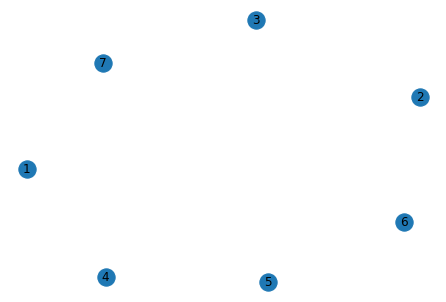

In [14]:
G.add_nodes_from([1,2,3,4,5,6,7])
nx.draw(G, with_labels=True)

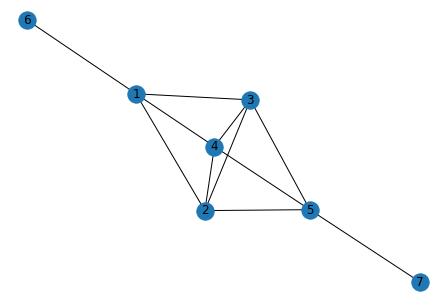

In [15]:
G.add_edges_from((
    (1,2), (1,3), (1,4), (1,6),
    (2,3), (2,4), (2,5),
    (3,4), (3,5),
    (4,5),
    (5,7),
))
nx.draw(G, with_labels=True)

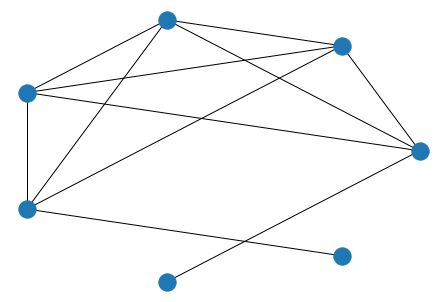

In [16]:
nx.draw_circular(G, with_labesl=True)

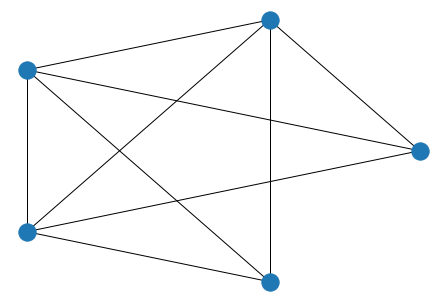

In [17]:
G.remove_nodes_from([6,7])
nx.draw_circular(G)

## The Shapiro Graph

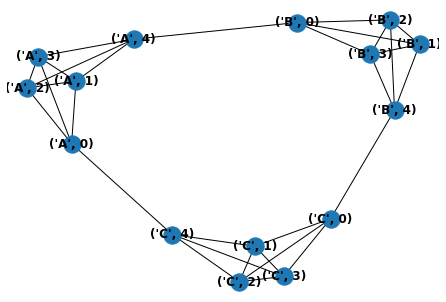

In [18]:
#def graph_pentagon(label='A'):

def graph_pentagon(label='A', weight=1):
    G = nx.Graph()
    G.add_nodes_from(zip([label]*5, range(5)))

    nodes_list = list(G.nodes)
    border_nodes = [nodes_list[0], nodes_list[-1]]
    for i, node_1 in enumerate(nodes_list[:-1]):
        for node_2 in nodes_list[i+1:]:
            if node_1 in border_nodes and node_2 in border_nodes: 
                continue
            G.add_edge(node_1, node_2, weight=weight)
    return G

def graph_shapiro(labels='ABC', weight=1):
    G = nx.Graph()

    for label in labels:
        pentagon = graph_pentagon(label)
        G.add_nodes_from(pentagon)
        G.add_edges_from(pentagon.edges, weight=weight)

    for i, label in enumerate(labels[:-1]):
        G.add_edge((label,4), (labels[i+1],0), weight=weight)
        G.add_edge((label,0), (labels[i-1],4), weight=weight)

    return G

G = graph_shapiro()
nx.draw(G, with_labels=True, font_weight='bold')

## Random Walk

### Random Step

In [19]:
G.nodes

NodeView((('A', 0), ('A', 1), ('A', 2), ('A', 3), ('A', 4), ('B', 0), ('B', 1), ('B', 2), ('B', 3), ('B', 4), ('C', 0), ('C', 1), ('C', 2), ('C', 3), ('C', 4)))

In [20]:
a = G[('A',0)]

In [22]:
nx.utils.weighted_choice?

Signature: nx.utils.weighted_choice(mapping, seed=None)
Docstring:
Returns a single element from a weighted sample.

The input is a dictionary of items with weights as values.
File:      ~/miniconda3/envs/g2/lib/python3.8/site-packages/networkx/utils/random_sequence.py
Type:      function


In [23]:
nx.utils.weighted_choice(a)

TypeError: unsupported operand type(s) for +: 'int' and 'dict'

In [24]:
@nx.utils.py_random_state(1)
def weighted_sample(node, seed=None):
    """Slightly modified version of ``nx.utils.weighted_choice`` to handle views

    Parameters
    ----------
    node : AtlasView
        A view of a node, containing all its neighbors
        
    Returns
    -------
    step : tuple
        Identifier for the sampled node
    """
    # use roulette method
    rnd = seed.random() * sum([n['weight'] for n in node.values()])
    for k, w in node.items():
        rnd -= w['weight']
        if rnd < 0:
            return k

weighted_sample(a)

('A', 3)

In [25]:
a

AtlasView({('A', 1): {'weight': 1}, ('A', 2): {'weight': 1}, ('A', 3): {'weight': 1}, ('C', 4): {'weight': 1}})

In [26]:
many_samples = [weighted_sample(a) for _ in range(100000)]

In [27]:
np.unique(many_samples)

array(['1', '2', '3', '4', 'A', 'C'], dtype='<U1')

In [28]:
for a_element in a.keys():
    print(many_samples.count(a_element))

25109
24735
25149
25007


### Full Random Walk

In [29]:
def random_walk(G, source=None, steps=None):
    # Choose a start position
    source = source or list(G.nodes)[np.random.choice(len(G.nodes))]
    assert source in list(G.nodes)
    
    while steps != 0:
        position = weighted_sample(G[source])
        yield source, position
        source = position
        if isinstance(steps, (int, float)):
            steps -= 1
            
walk = random_walk(G)

In [30]:
for i in range(15):
    print(next(walk))

(('B', 3), ('B', 0))
(('B', 0), ('B', 1))
(('B', 1), ('B', 0))
(('B', 0), ('A', 4))
(('A', 4), ('B', 0))
(('B', 0), ('A', 4))
(('A', 4), ('A', 3))
(('A', 3), ('A', 2))
(('A', 2), ('A', 3))
(('A', 3), ('A', 2))
(('A', 2), ('A', 1))
(('A', 1), ('A', 3))
(('A', 3), ('A', 1))
(('A', 1), ('A', 2))
(('A', 2), ('A', 0))


In [31]:
all_nodes = [list(G.nodes)[np.random.choice(len(G.nodes))] for _ in range(1000000)]
for node in set(all_nodes):
    print(node, all_nodes.count(node))

('C', 1) 66773
('B', 4) 66765
('B', 0) 66669
('C', 0) 66788
('A', 2) 66397
('B', 3) 66677
('C', 3) 66909
('A', 1) 66162
('B', 2) 66479
('C', 2) 66598
('A', 4) 66941
('A', 0) 66858
('A', 3) 66894
('C', 4) 66417
('B', 1) 66673


## Eulerian Path (Walk)

In [46]:
euler = nx.algorithms.euler.eulerian_path(G, source=list(G.nodes)[np.random.choice(len(G.nodes))])

In [47]:
for i in range(50):
    print(next(euler))

(('A', 4), ('A', 3))
(('A', 3), ('A', 2))
(('A', 2), ('A', 4))
(('A', 4), ('B', 0))
(('B', 0), ('B', 3))
(('B', 3), ('B', 4))
(('B', 4), ('B', 2))
(('B', 2), ('B', 3))
(('B', 3), ('B', 1))
(('B', 1), ('B', 2))
(('B', 2), ('B', 0))
(('B', 0), ('B', 1))
(('B', 1), ('B', 4))
(('B', 4), ('C', 0))
(('C', 0), ('C', 3))
(('C', 3), ('C', 4))
(('C', 4), ('C', 2))
(('C', 2), ('C', 3))
(('C', 3), ('C', 1))
(('C', 1), ('C', 2))
(('C', 2), ('C', 0))
(('C', 0), ('C', 1))
(('C', 1), ('C', 4))
(('C', 4), ('A', 0))
(('A', 0), ('A', 3))
(('A', 3), ('A', 1))
(('A', 1), ('A', 2))
(('A', 2), ('A', 0))
(('A', 0), ('A', 1))
(('A', 1), ('A', 4))


StopIteration: 

In [34]:
def euler_walk(G, source=None):
    all_nodes = list(G.nodes)
    source = source or all_nodes[np.random.choice(len(G.nodes))]
    assert source in all_nodes
    
    return nx.algorithms.euler.eulerian_path(G, source=source)

In [41]:
euler = euler_walk(G)

In [42]:
for i in range(16):
    print(next(euler))

(('A', 2), ('A', 4))
(('A', 4), ('A', 3))
(('A', 3), ('A', 1))
(('A', 1), ('A', 4))
(('A', 4), ('B', 0))
(('B', 0), ('B', 3))
(('B', 3), ('B', 4))
(('B', 4), ('B', 2))
(('B', 2), ('B', 3))
(('B', 3), ('B', 1))
(('B', 1), ('B', 2))
(('B', 2), ('B', 0))
(('B', 0), ('B', 1))
(('B', 1), ('B', 4))
(('B', 4), ('C', 0))


StopIteration: 

## Hamiltonian Walk

This is NP-hard so starting from a brute force implementation found in this [gist](https://gist.github.com/mikkelam/ab7966e7ab1c441f947b). Code is below:

In [67]:
import networkx as nx

def hamilton(G):
    F = [(G,[list(G.nodes())[0]])]
    n = G.number_of_nodes()
    while F:
        graph,path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g,conf_p))
        for g,p in confs:
            if len(p)==n:
                return p
            else:
                F.append((g,p))
    return None

hamilton(G)

[('A', 0),
 ('C', 4),
 ('C', 3),
 ('C', 2),
 ('C', 1),
 ('C', 0),
 ('B', 4),
 ('B', 3),
 ('B', 2),
 ('B', 1),
 ('B', 0),
 ('A', 4),
 ('A', 3),
 ('A', 2),
 ('A', 1)]

0

In [175]:
def hamilton_random_iter(G, source=None):
    F = [(G, [list(G.nodes)[np.random.choice(len(G.nodes))]])]
    n = G.number_of_nodes()
    while F:
        graph, path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g, conf_p))
            
        for g, p in confs:
            if len(p) == n:
                # Reverse the list 50% of the time
                if np.random.choice(2):
                    p.reverse()
                
                # If a source was specified, rotate the list until source is the start elem
                if source:
                    start = p[0]
                    while start != source:
                        p.append(p.pop(0))
                        start = p[0]
                
                # Create shifted list
                p_shift = list(p)
                p_shift.append(p_shift.pop(0))
                return iter(zip(p, p_shift))
            else:
                F.append((g,p))
    return None

list(hamilton_random_iter(G, ('A', 0)))

[(('C', 2), ('C', 4)),
 (('C', 4), ('C', 3)),
 (('C', 3), ('C', 1)),
 (('C', 1), ('C', 0)),
 (('C', 0), ('B', 4)),
 (('B', 4), ('B', 3)),
 (('B', 3), ('B', 2)),
 (('B', 2), ('B', 1)),
 (('B', 1), ('B', 0)),
 (('B', 0), ('A', 4)),
 (('A', 4), ('A', 3)),
 (('A', 3), ('A', 2)),
 (('A', 2), ('A', 1)),
 (('A', 1), ('A', 0)),
 (('A', 0), ('C', 2))]

In [176]:
%%timeit 
list(hamilton_random_iter(G, ('A', 0)))

9.94 ms ± 637 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [90]:
a = list(range(5))
a

[0, 1, 2, 3, 4]

In [120]:
b = list(a)
b.append(b.pop(0))
print(list(zip(a, b)))

[(0, 1), (1, 2), (2, 3), (3, 4), (4, 0)]


In [159]:
b.reverse()
b

[1, 2, 3, 4, 0]

In [55]:
F = [(G, [list(G.nodes())[0]])]
F

[(<networkx.classes.graph.Graph at 0x7ff3942d9190>, [('A', 0)])]

In [49]:
graph, path = F.pop()
graph, path

(<networkx.classes.graph.Graph at 0x7ff3942d9190>, [('A', 0)])

In [50]:
F

[]

In [53]:
list(graph.neighbors(path[-1]))

[('A', 1), ('A', 2), ('A', 3), ('C', 4)]

In [59]:
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

## Reworking the Graph to use Ints

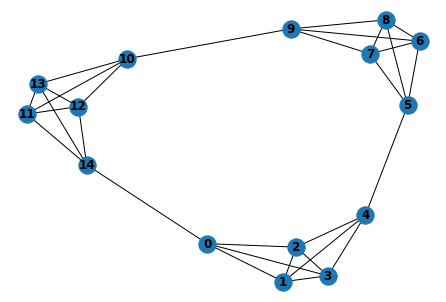

In [201]:
def schapiro_pentagon(offset=0, weight=1):
    """Creates a pentagon of nodes and edges like in the paper.
    
    Parameters
    ----------
    offset : int (optional)
    	Offset to start the numbering of the nodes

    weight : int (optional)
    	Weight of edges.

    Returns
    -------
    G : nx.Graph
    	Graph that contains the nodes and edges for the pentagon
    """
    G = nx.Graph()
    G.add_nodes_from(range(offset, offset+5))

    nodes_list = list(G.nodes)
    border_nodes = [nodes_list[0], nodes_list[-1]]
    for i, node_1 in enumerate(nodes_list[:-1]):
        for node_2 in nodes_list[i+1:]:
            if node_1 in border_nodes and node_2 in border_nodes:
                continue
            G.add_edge(node_1, node_2, weight=weight)
    return G

def schapiro_graph(n_pentagons=3, weight=1):
    """Creates the full schapiro graph that is a collection of pentagon nodes.

    Parameters
    ----------
    n_pentagons : int (optional)
    	Number of pentagons to include in the graph

    weight : int (optional)
    	Weight of edges.

    Returns
    -------
    G : nx.Graph
    	Graph that contains the nodes and edges for the full schapiro graph
    """    
    G = nx.Graph()

    # Add each community to the full graph
    pentagons = [schapiro_pentagon(offset=i*5) for i in range(n_pentagons)]
    [G.add_edges_from(pentagon.edges, weight=weight) for pentagon in pentagons]

    # Connect each community together
    for i in range(n_pentagons-1):
        G.add_edge(list(pentagons[i])[0], list(pentagons[i-1])[-1], weight=weight)
        G.add_edge(list(pentagons[i])[4], list(pentagons[i+1])[0], weight=weight)

    return G

nx.draw(schapiro_graph(), with_labels=True, font_weight='bold')

## Checking Walks Still Work

In [202]:
@nx.utils.py_random_state(1)
def weighted_sample(node, seed=None):
    """Slightly modified version of ``nx.utils.weighted_choice`` to handle views

    Parameters
    ----------
    node : AtlasView
        A view of a node, containing all its neighbors
        
    Returns
    -------
    step : tuple
        Identifier for the sampled node
    """
    # use roulette method
    rnd = seed.random() * sum([n['weight'] for n in node.values()])
    for k, w in node.items():
        rnd -= w['weight']
        if rnd < 0:
            return k

def walk_random(G, source=None, steps=None):
    """Iterator that yields the start and final position after each step

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    steps : int or None (optional)
    	Number of steps to take before terminating. Yields indefinitely if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """
    # Choose a start position
    source = source or list(G.nodes)[np.random.choice(len(G.nodes))]
    assert source in list(G.nodes)

    # Keep taking steps indefinitely or until steps reaches zero
    while steps != 0:
        position = weighted_sample(G[source])
        yield source, position
        source = position
        if isinstance(steps, (int, float)):
            steps -= 1

def walk_euclid(G, source=None):
    """Iterator that yields the start and final position after each step on a
    euclidean walk (visit every edge once).

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """    
    source = source or list(G.nodes)[np.random.choice(len(G.nodes))]
    assert source in list(G.nodes)
    
    return nx.algorithms.euler.eulerian_path(G, source=source)

def walk_hamiltonian(G, source=None):
    """Iterator that yields a start and final position after each step on a
    hamiltonian walk (visit every node once).

    Discovering hamiltonian paths is a NP-complete problem so beware using this
    on larger graphs as this is a brute force search implementation.

    Searches through all paths to find the first hamiltonian path it encounters.
    Once it finds it, the path is reversed 50% of the time, and rotated to start
    at ``source`` if passed.

    Parameters
    ----------
    G : nx.Graph
    	Graph to be walked through

    source : hashable (optional)
    	Hashable type that identifies the start node to use in G. Randomly
    	chooses a node if None

    Yields
    ------
    (source, position) : (hashable, hashable)
    	The start and end node identifiers after each step
    """
    F = [(G, [list(G.nodes)[np.random.choice(len(G.nodes))]])]
    n = G.number_of_nodes()
    while F:
        graph, path = F.pop()
        confs = []
        neighbors = (node for node in graph.neighbors(path[-1]) 
                     if node != path[-1]) #exclude self loops
        for neighbor in neighbors:
            conf_p = path[:]
            conf_p.append(neighbor)
            conf_g = nx.Graph(graph)
            conf_g.remove_node(path[-1])
            confs.append((conf_g, conf_p))
            
        for g, p in confs:
            if len(p) == n:
                # Reverse the list 50% of the time
                if np.random.choice(2):
                    p.reverse()
                
                # If a source was specified, rotate the list until source is
                # the start elem
                if source:
                    start = p[0]
                    while start != source:
                        p.append(p.pop(0))
                        start = p[0]
                
                # Create shifted list
                p_shift = list(p)
                p_shift.append(p_shift.pop(0))
                return iter(zip(p, p_shift))
            else:
                F.append((g,p))
    return None


In [206]:
list(walk_random(schapiro_graph(), steps=15))

[(11, 14),
 (14, 0),
 (0, 1),
 (1, 0),
 (0, 14),
 (14, 12),
 (12, 10),
 (10, 9),
 (9, 7),
 (7, 6),
 (6, 8),
 (8, 5),
 (5, 7),
 (7, 5),
 (5, 4)]

In [208]:
list(walk_euclid(schapiro_graph()))

[(14, 13),
 (13, 12),
 (12, 14),
 (14, 11),
 (11, 13),
 (13, 10),
 (10, 12),
 (12, 11),
 (11, 10),
 (10, 9),
 (9, 8),
 (8, 7),
 (7, 9),
 (9, 6),
 (6, 8),
 (8, 5),
 (5, 7),
 (7, 6),
 (6, 5),
 (5, 4),
 (4, 3),
 (3, 2),
 (2, 4),
 (4, 1),
 (1, 3),
 (3, 0),
 (0, 2),
 (2, 1),
 (1, 0),
 (0, 14)]

In [209]:
list(walk_hamiltonian(schapiro_graph()))

[(9, 10),
 (10, 13),
 (13, 12),
 (12, 11),
 (11, 14),
 (14, 0),
 (0, 3),
 (3, 2),
 (2, 1),
 (1, 4),
 (4, 5),
 (5, 8),
 (8, 7),
 (7, 6),
 (6, 9)]